In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, pnorm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
pdata = pd.read_csv("./t2_generated.csv")


In [3]:
CUTOFF  = 12
N_SOLUTIONS = 64
gamma_vals = np.logspace(-4, -1, N_SOLUTIONS)



coords = np.array([pdata.x , pdata.y]).T
deflection_x = np.array(pdata.u_x)
deflection_y = np.array(pdata.u_y)
boundary = np.array(pdata.boundary)

x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=0
condition_outside = (distances2d>0) * (distances2d<=CUTOFF)

del distances2d, mask, boundary2d
gc.collect()



0

In [4]:
x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)


Size of the problem is 2904


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:

obs_x_in = deflection_x[condition_inside]
obs_x_out = deflection_x[condition_outside]

obs_y_in = deflection_y[condition_inside]
obs_y_out = deflection_y[condition_outside]

n_in = len(x_in)
n_out = len(x_out)


gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma = Variable(n_in,2)
predicted_in_x = G_in_in_xx * sigma[:,0] + G_in_in_xy * sigma[:,1]
predicted_out_x = G_out_in_xx * sigma[:,0] + G_out_in_xy * sigma[:,1]
predicted_in_y = G_in_in_yx * sigma[:,0] + G_in_in_yy * sigma[:,1]
predicted_out_y = G_out_in_yx * sigma[:,0] + G_out_in_yy * sigma[:,1]

error = sum_squares(obs_x_in - predicted_in_x) + sum_squares(obs_x_out - predicted_out_x) + \
    sum_squares(obs_y_in - predicted_in_y) + sum_squares(obs_y_out - predicted_out_y)

forceconstraints = [sum_entries(sigma[:,0])==0, sum_entries(sigma[:,1])==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma[:,1]) - mul_elemwise(y_in-y_center,sigma[:,0]))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []


$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [6]:
regularity_penalty = sum_entries(pnorm(sigma,2, axis=1))
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_values = []

u_x_values = []


In [7]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-7, reltol = 1e-6,
                   abstol = 1e-7)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_values.append(sigma.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma[:,0].value.reshape((n_in,))
    s_y[condition_inside].flat = sigma[:,1].value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value
    
    return np.array([sigma[:,0].value, sigma[:,1].value]).T, error.value, regularity_penalty.value, val

    return np.array([s_x, s_y]).T,  error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
pad_results = [invert_one(val) for val in gamma_vals]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  1.1540e+00  9.5535e-01  1e+02  6e-01  2e+00  3e-01
 2:  1.3720e+00  1.3148e+00  2e+01  9e-02  2e-01  1e-02
 3:  1.3251e+00  1.3156e+00  6e-01  1e-02  4e-02  1e-03
 4:  1.3110e+00  1.3100e+00  1e-02  2e-03  5e-03  5e-04
 5:  1.3092e+00  1.3090e+00  7e-04  2e-04  5e-04  3e-05
 6:  1.3090e+00  1.3090e+00  8e-05  2e-05  6e-05  4e-06
 7:  1.3090e+00  1.3090e+00  1e-05  3e-06  8e-06  6e-07
 8:  1.3090e+00  1.3090e+00  6e-07  2e-07  4e-07  3e-08
 9:  1.3090e+00  1.3090e+00  1e-08  3e-09  8e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  1.1628e+00  9.6263e-01  1e+02  6e-01  2e+00  3e-01
 2:  1.3792e+00  1.3197e+00  2e+01  9e-02  2e-01  1e-02
 3:  1.3250e+00  1.3156e+00  6e-01  1e-02  4e-02  2e-03
 4:  1.3117e+00  1.3105e+00  2e-02  2e-03  5e-03  4e-04
 5:  1.3093e+00  1.3092e+00 

 5:  1.3119e+00  1.3118e+00  1e-03  3e-04  9e-04  1e-04
 6:  1.3119e+00  1.3118e+00  2e-04  5e-05  1e-04  2e-05
 7:  1.3119e+00  1.3119e+00  2e-05  5e-06  1e-05  2e-06
 8:  1.3119e+00  1.3119e+00  1e-06  4e-07  9e-07  1e-07
 9:  1.3119e+00  1.3119e+00  1e-07  4e-08  1e-07  2e-08
10:  1.3119e+00  1.3119e+00  1e-08  4e-09  2e-08  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  1.3682e+00  1.1454e+00  1e+02  7e-01  2e+00  3e-01
 2:  1.4219e+00  1.3426e+00  1e+01  1e-01  3e-01  2e-02
 3:  1.3330e+00  1.3236e+00  3e-01  2e-02  5e-02  6e-03
 4:  1.3147e+00  1.3137e+00  1e-02  2e-03  6e-03  8e-04
 5:  1.3124e+00  1.3123e+00  1e-03  3e-04  8e-04  1e-04
 6:  1.3123e+00  1.3123e+00  1e-04  5e-05  1e-04  2e-05
 7:  1.3123e+00  1.3123e+00  1e-05  4e-06  1e-05  2e-06
 8:  1.3123e+00  1.3123e+00  1e-06  3e-07  9e-07  1e-07
 9:  1.3123e+00  1.3123e+00  1e-07  5e-08  1e-07  2e-08
10:  1.3123e+00  1.3123e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  1.6840e+00  1.3257e+00  2e+02  1e+00  3e+00  4e-01
 2:  1.4557e+00  1.3967e+00  8e+00  2e-01  4e-01  8e-02
 3:  1.3188e+00  1.3308e+00  3e-01  4e-02  1e-01  4e-02
 4:  1.3281e+00  1.3255e+00  2e-02  5e-03  1e-02  1e-03
 5:  1.3224e+00  1.3222e+00  2e-03  5e-04  1e-03  2e-04
 6:  1.3225e+00  1.3225e+00  3e-04  9e-05  2e-04  4e-05
 7:  1.3225e+00  1.3225e+00  1e-04  3e-05  7e-05  1e-05
 8:  1.3225e+00  1.3225e+00  1e-05  3e-06  9e-06  1e-06
 9:  1.3225e+00  1.3225e+00  3e-06  8e-07  2e-06  3e-07
10:  1.3225e+00  1.3225e+00  8e-07  2e-07  5e-07  7e-08
11:  1.3225e+00  1.3225e+00  1e-07  4e-08  1e-07  1e-08
12:  1.3225e+00  1.3225e+00  8e-09  3e-09  3e-08  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  1.7100e+00  1.3443e+00  2e+02  1e+00  3e+00  4e-01
 2:  1.4582e+00  1.4029e+00 

 1:  1.7056e+00  1.4684e+00  1e+02  1e+00  3e+00  8e-01
 2:  1.4759e+00  1.4693e+00  5e+00  2e-01  5e-01  2e-01
 3:  1.3299e+00  1.3666e+00  2e-01  4e-02  9e-02  7e-02
 4:  1.3489e+00  1.3498e+00  1e-02  3e-03  9e-03  4e-03
 5:  1.3504e+00  1.3506e+00  3e-03  8e-04  2e-03  8e-04
 6:  1.3509e+00  1.3510e+00  1e-03  3e-04  9e-04  3e-04
 7:  1.3511e+00  1.3511e+00  3e-04  7e-05  2e-04  6e-05
 8:  1.3511e+00  1.3511e+00  5e-05  1e-05  3e-05  1e-05
 9:  1.3511e+00  1.3511e+00  1e-05  3e-06  6e-06  2e-06
10:  1.3511e+00  1.3511e+00  2e-06  6e-07  1e-06  4e-07
11:  1.3511e+00  1.3511e+00  5e-07  1e-07  3e-07  7e-08
12:  1.3511e+00  1.3511e+00  4e-08  1e-08  9e-08  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  1.6633e+00  1.4700e+00  1e+02  1e+00  3e+00  8e-01
 2:  1.4755e+00  1.4760e+00  5e+00  2e-01  5e-01  2e-01
 3:  1.3318e+00  1.3706e+00  2e-01  4e-02  9e-02  7e-02
 4:  1.3525e+00  1.3544e+0

 7:  1.4212e+00  1.4213e+00  5e-04  1e-04  3e-04  2e-04
 8:  1.4214e+00  1.4215e+00  7e-05  1e-05  3e-05  3e-05
 9:  1.4215e+00  1.4215e+00  5e-06  1e-06  2e-06  2e-06
10:  1.4215e+00  1.4215e+00  8e-07  2e-07  4e-07  3e-07
11:  1.4215e+00  1.4215e+00  2e-07  4e-08  1e-07  7e-08
12:  1.4215e+00  1.4215e+00  1e-08  2e-09  6e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  2e+01  1e+00
 1:  9.1535e-01  1.3064e+00  7e+01  1e+00  3e+00  1e+00
 2:  1.4096e+00  1.5026e+00  3e+00  2e-01  4e-01  2e-01
 3:  1.3457e+00  1.4190e+00  2e-01  3e-02  8e-02  1e-01
 4:  1.4169e+00  1.4269e+00  2e-02  5e-03  1e-02  1e-02
 5:  1.4306e+00  1.4327e+00  5e-03  1e-03  2e-03  3e-03
 6:  1.4331e+00  1.4337e+00  2e-03  3e-04  8e-04  9e-04
 7:  1.4339e+00  1.4341e+00  5e-04  1e-04  2e-04  2e-04
 8:  1.4342e+00  1.4342e+00  7e-05  1e-05  3e-05  3e-05
 9:  1.4342e+00  1.4342e+00  6e-06  1e-06  3e-06  2e-06
10:  1.4342e+00  1.4342e+0

 7:  1.6260e+00  1.6285e+00  1e-02  1e-03  2e-03  3e-03
 8:  1.6305e+00  1.6311e+00  3e-03  3e-04  6e-04  8e-04
 9:  1.6316e+00  1.6318e+00  8e-04  7e-05  2e-04  2e-04
10:  1.6320e+00  1.6320e+00  1e-04  1e-05  2e-05  3e-05
11:  1.6320e+00  1.6321e+00  1e-05  1e-06  2e-06  3e-06
12:  1.6321e+00  1.6321e+00  9e-07  7e-08  2e-07  2e-07
13:  1.6321e+00  1.6321e+00  1e-07  9e-09  2e-08  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  7e+00  1e+01  1e+00
 1: -1.4077e+00  4.2488e-01  3e+01  8e-01  2e+00  2e+00
 2:  8.5031e-01  1.2917e+00  4e+00  2e-01  4e-01  6e-01
 3:  1.3367e+00  1.5042e+00  7e-01  5e-02  1e-01  2e-01
 4:  1.5031e+00  1.5761e+00  3e-01  2e-02  5e-02  9e-02
 5:  1.5568e+00  1.6082e+00  2e-01  2e-02  4e-02  6e-02
 6:  1.6290e+00  1.6460e+00  7e-02  6e-03  1e-02  2e-02
 7:  1.6380e+00  1.6507e+00  6e-02  5e-03  1e-02  2e-02
 8:  1.6589e+00  1.6625e+00  2e-02  1e-03  3e-03  5e-03
 9:  1.6650e+00  1.6658e+0

12:  2.1932e+00  2.1932e+00  1e-06  4e-08  5e-08  2e-07
Optimal solution found.


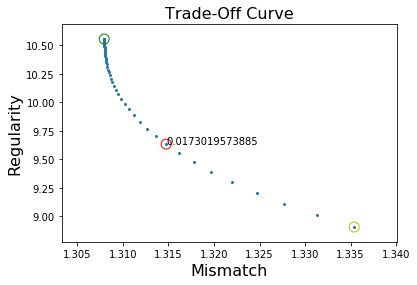

In [8]:
data_error = [res[1] for res in pad_results[:-8]]
reg_error = [res[2] for res in pad_results[:-8]]
lvals = [res[3] for res in pad_results[:-8]]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.scatter( data_error, reg_error,s=4)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

(119.94999999999999, 209.71000000000001)

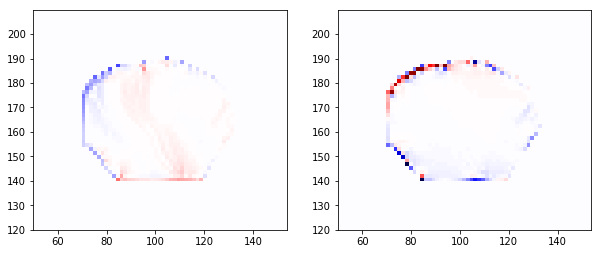

In [9]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[best][0][0][:,0]
s_y[condition_inside] = pad_results[best][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

In [10]:
import pickle
import gzip

with gzip.open('../results/isotropic_L1_synthetic_results.gz','wb') as f:
    pickle.dump(pad_results + [ [x_obs_positions,y_obs_positions]],f)